#1. Installing required libraries  | use Gpu Session

In [1]:
!pwd

/content


In [2]:
!pip install -Uqq fastbook
import fastbook
#hide
from fastbook import *
from fastai.vision.widgets import *

     |████████████████████████████████| 727kB 8.0MB/s 
     |████████████████████████████████| 51kB 7.1MB/s 
     |████████████████████████████████| 1.0MB 12.6MB/s 
     |████████████████████████████████| 51kB 7.9MB/s 
     |████████████████████████████████| 194kB 45.5MB/s 
     |████████████████████████████████| 51kB 8.8MB/s 
     |████████████████████████████████| 92kB 12.0MB/s 
     |████████████████████████████████| 40kB 7.1MB/s 
     |████████████████████████████████| 51kB 8.5MB/s 
     |████████████████████████████████| 61kB 9.9MB/s 
     |████████████████████████████████| 2.6MB 54.7MB/s 


#2. download our data 


1.   we will use microsoft azure ping API
2.   we will download the data to Google deive for further projects 
3.   our projectt is about binary classification of engineers or workers wearing a helmet or not 
4.   we will use ResNet CNN model 



In [4]:
# the key or token to invoke the EndPoint 
key = os.environ.get('AZURE_SEARCH_KEY', 'ff045c8dec5745f0927e5a8b966885b8')


In [5]:
search_images_bing

<function fastbook.search_images_bing>

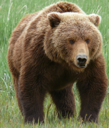

In [6]:
#let's try a single image first | download_url(..) is afunction in Fast.ai
ims = ['http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly%2BBear%2BWildlife.jpg']
dest = '/content/grizzly.jpg'
download_url(ims[0], dest)
im = Image.open(dest)
im.to_thumb(128,128)
#here you should see an image of grizzly bear

In [9]:
person_types = 'construction workers wear safety helmet','person in street'
path = Path('types')


In [10]:
if not path.exists():
    path.mkdir()
    for o in person_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, o)
        download_images(dest, urls=results.attrgot('content_url'))

**let's zip the folder and download it so we can work on it again**

In [ ]:
!zip -r /content/types.zip /content/types

In [14]:
fns = get_image_files(path);fns

(#295) [Path('types/person in street/00000093.jpg'),Path('types/person in street/00000106.jpg'),Path('types/person in street/00000114.jpg'),Path('types/person in street/00000043.jpg'),Path('types/person in street/00000031.jpg'),Path('types/person in street/00000136.jpg'),Path('types/person in street/00000058.jpg'),Path('types/person in street/00000103.png'),Path('types/person in street/00000000.jpg'),Path('types/person in street/00000076.jpg')...]

*now we have root folder"types" with the target classification sub-folders*

In [15]:
# verify that we have imgs only
failed = verify_images(fns);failed

(#18) [Path('types/person in street/00000060.jpg'),Path('types/person in street/00000116.jpg'),Path('types/person in street/00000010.jpg'),Path('types/person in street/00000095.jpg'),Path('types/person in street/00000055.jpg'),Path('types/construction workers wear safety helmet/00000043.jpg'),Path('types/construction workers wear safety helmet/00000031.jpg'),Path('types/construction workers wear safety helmet/00000015.jpg'),Path('types/construction workers wear safety helmet/00000035.jpg'),Path('types/construction workers wear safety helmet/00000041.jpg')...]

In [ ]:
# unlink (remove) the images that failed from the dir
failed.map(Path.unlink);

In [19]:
failed = verify_images(fns);failed

(#18) [Path('types/person in street/00000060.jpg'),Path('types/person in street/00000116.jpg'),Path('types/person in street/00000010.jpg'),Path('types/person in street/00000095.jpg'),Path('types/person in street/00000055.jpg'),Path('types/construction workers wear safety helmet/00000043.jpg'),Path('types/construction workers wear safety helmet/00000031.jpg'),Path('types/construction workers wear safety helmet/00000015.jpg'),Path('types/construction workers wear safety helmet/00000035.jpg'),Path('types/construction workers wear safety helmet/00000041.jpg')...]

## 3. Create our DataLoaders from DataBlocks 
To turn our downloaded data into a `DataLoaders` object we need to tell fastai at least four things:

- What kinds of data we are working with
- How to get the list of items
- How to label these items
- How to create the validation set

In [23]:
#DataBlock -->  Generic container to quickly build Datasets and DataLoaders
types = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [24]:
# We still need to tell fastai the actual source of our data—in this case,
# the path where the images can be found
dls = types.dataloaders(path)

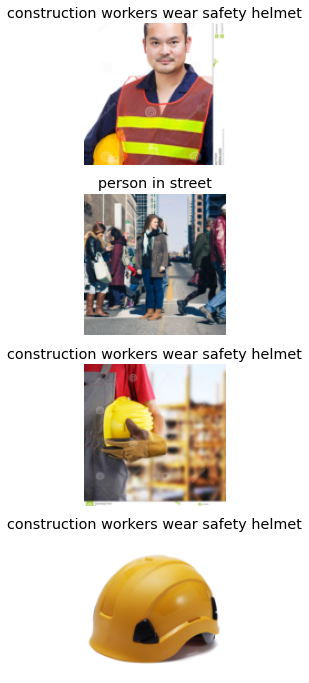

In [26]:
dls.valid.show_batch(max_n=4, nrows=4)

**let's Try Various data augmentation methods**


*   squishing
*   padding 
*   RandomResizedCrop



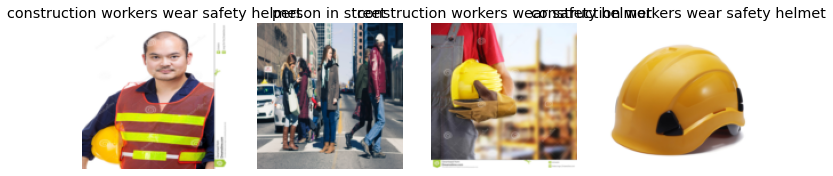

In [27]:
types = types.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = types.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

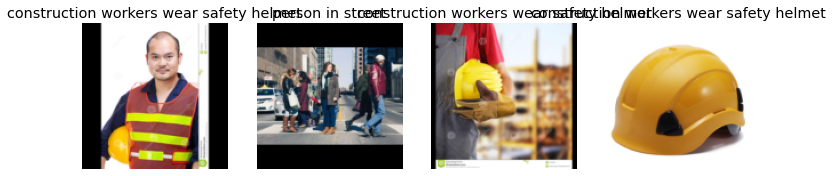

In [29]:
types = types.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = types.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

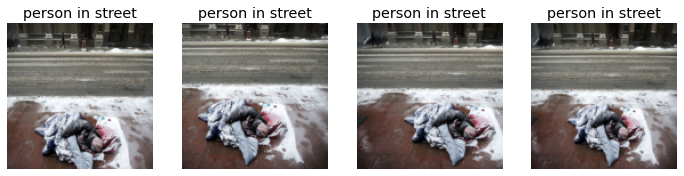

In [30]:
types = types.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = types.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

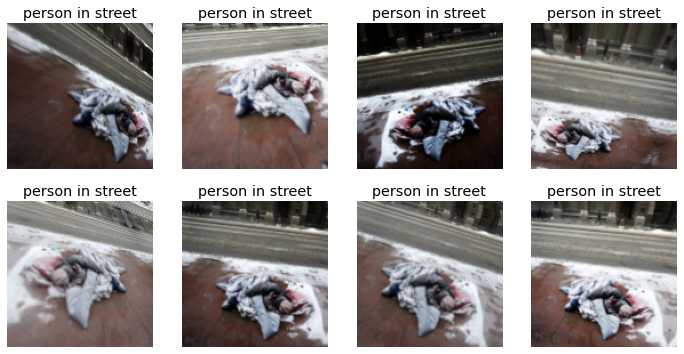

In [31]:
# aug_transforms performs data augmentation for you 
types = types.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = types.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

##4.Data Augmentation | Model Training

In [32]:
# now we settle down with RandomizedCrop and default data augmentation 
types = types.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = types.dataloaders(path)

In [33]:
# Train CNN Resnet with 18 layer | actually we fine tune it 
#( use transfer learning from a pretrained-model on ImageNet)
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


## 5.Error analysis | Data Cleaning 

/usr/local/lib/python3.6/dist-packages/fastai/interpret.py:88: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


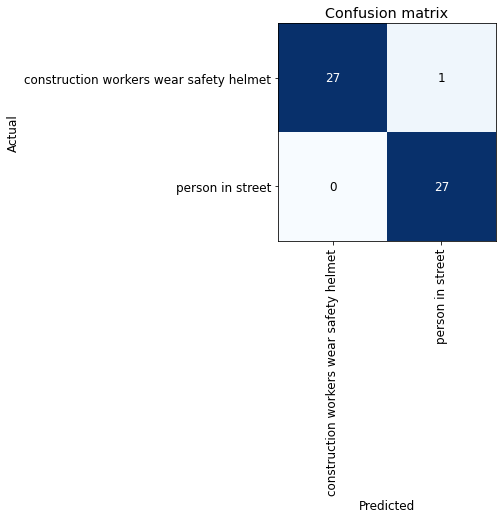

In [35]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

each image is labeled with four things: **prediction, actual (target label), loss, and probability**. The probability here is the confidence level, from zero to one

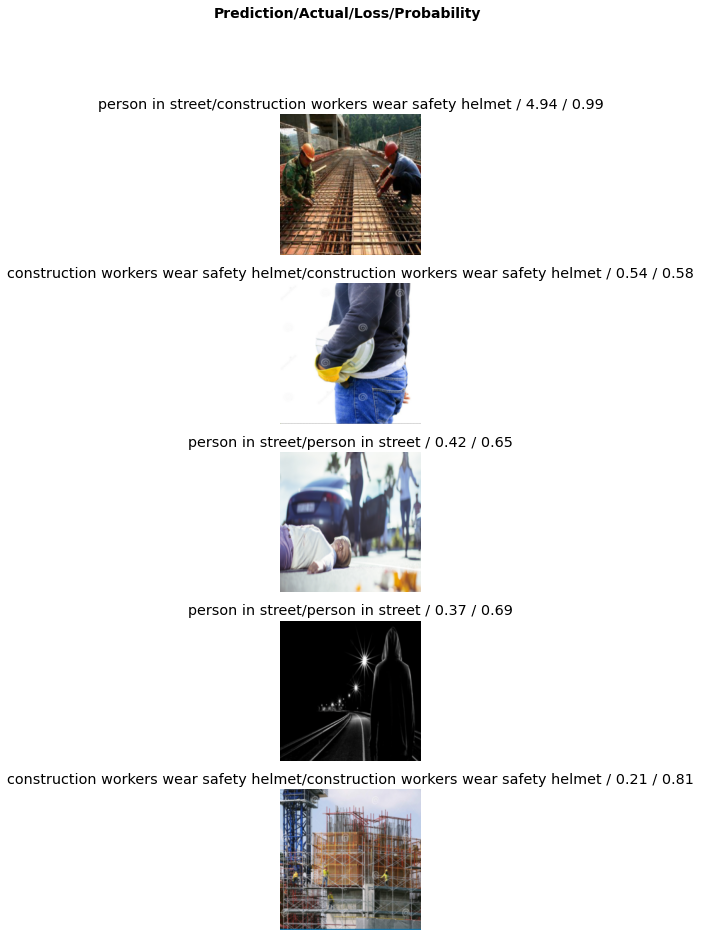

In [36]:
interp.plot_top_losses(5,nrows=5)

**high confidence (probability) in a prediction that is different from the actual target results in a big loss**

The intuitive approach to doing data cleaning is to do it before you train a model. But as you've seen in this case, a model can actually help you find data issues more quickly and easily. So, we normally prefer to train a quick and simple model first, and then use it to help us with data cleaning.

In [37]:
#ImageClassifierCleaner that allows you to choose a category and the training versus validation set and view the highest-loss images (in order)
#, along with menus to allow images to be selected for removal or relabeling
cleaner = ImageClassifierCleaner(learn)
cleaner

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [38]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink() # --> unlink photos
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat) # --> change Types  

# 6. Turning Your Model into an Online Application
Once you've got a model you're happy with, you need to save it, so that you can then copy it over to a server where you'll use it in production.

In [39]:
#save the model architecture and the parameters as .pkl file
learn.export()

In [40]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [41]:
#use the model for inference as a simple function
learn_inf = load_learner(path/'export.pkl')

In [42]:
learn_inf.predict('/content/types/construction workers wear safety helmet/00000006.jpg')

('construction workers wear safety helmet',
 tensor(0),
 tensor([1.0000e+00, 1.6395e-07]))

tensor([1.0000e+00, 1.6395e-07]))
--> interpret it as the prob of 1st target is 1.00 and so on 

In [43]:
# vocab is a map from nums to text  
#order of categories
learn_inf.dls.vocab

(#2) ['construction workers wear safety helmet','person in street']

#7.Creating a Notebook App from the Model
**using ipywidgets and voila**

In [44]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [45]:
#create an image
img = PILImage.create(btn_upload.data[-1])

In [46]:
#display the img
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [47]:
pred,pred_idx,probs = learn_inf.predict(img)

In [48]:
#display probabilities as label
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: construction workers wear safety helmet; Probability: 0.9284')

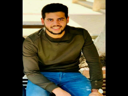

In [49]:
btn_run = widgets.Button(description='Classify')
btn_run

In [50]:
#event handler to be invoked on clicking the button
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [52]:
btn_upload = widgets.FileUpload();btn_upload

FileUpload(value={}, description='Upload')

In [53]:
#now let's put all of them in Vertical box 
VBox([widgets.Label('check safety!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

In [54]:
#install libraries for deploying your model
!pip install voila
!jupyter serverextension enable voila —sys-prefix

     |████████████████████████████████| 6.9MB 5.2MB/s 
     |████████████████████████████████| 112kB 59.3MB/s 
     |████████████████████████████████| 215kB 56.2MB/s 
     |████████████████████████████████| 552kB 57.5MB/s 
ERROR: nbdev 1.1.0 has requirement nbconvert<6, but you'll have nbconvert 6.0.7 which is incompatible.
  Found existing installation: jupyter-client 5.3.5
    Uninstalling jupyter-client-5.3.5:
      Successfully uninstalled jupyter-client-5.3.5
  Found existing installation: nbconvert 5.6.1
    Uninstalling nbconvert-5.6.1:
      Successfully uninstalled nbconvert-5.6.1


Enabling: voila
- Writing config: /root/.jupyter
    - Validating...
Error loading server extension voila
      X is voila importable?
Enabling: —sys-prefix
- Writing config: /root/.jupyter
    - Validating...
Error loading server extension —sys-prefix
      X is —sys-prefix importable?
